In [0]:
import random
import pandas as pd
import numpy as np

# Data generation

## Naive approach

### Libraries and classes

In [0]:
import networkx as nx
import matplotlib.pyplot as plt

In [0]:
class Traveller:
    def __init__(self, current_node=None, trip_size=10):
        self.current_node = current_node
        self.current_step = 0
        self.trip_size = trip_size
        self.first_node = current_node
        self.last_node = None
    
    def next_step(self, next_nodes):
        if self.is_finished():
            return False
        
        if len(next_nodes) == 0 or self.current_step == self.trip_size:
            self.last_node = self.current_node
            return False
        
        self.current_node = random.choice(next_nodes)
        self.current_step += 1
        return self.current_node
    
    def is_finished(self) -> bool:
        return self.last_node is not None

In [0]:
def generate_random_graph(nodes_amount=10):
    nodes = set(range(nodes_amount))
    edges = []
    for node in nodes:
        neighbours = random.choices(list(nodes - {node}), k=random.randint(0, len(nodes)))
        for neighbour in neighbours:
            edges.append((node, neighbour, {'weight': 0}))
    
    return nodes, edges

In [0]:
def generate_graphs(
    graphs_number=1, 
    iterations_number=50, 
    graph_size=(5,30), 
    initial_travellers=100,
    new_travellers_on_each_iteration=(0,10),
    trip_size=(5,20)):
  """
  Function to generate flows matrices and trips matrices

  Args:
    graphs_number (int): number of graphs to be generated 
    iteration_number (int): number of iterations in time series
    graph_size (tuple): parameters of even distribution for a number of a graph nodes 
    initial_travellers (int): number of travellers that exist at the first iteration
    new_travellers_on_each_iteration: (tuple): parameters of even distribution for a number of travellers being added on an each iteration
    trip_size (tuple): parameters of even distribution for steps number in a trip (a trip size is randomly picked for an each traveller)
  Returns:
    Two pandas dataframes.

    The first one contains flows data as rows of edges. It has the following columns:
      graph: id of a graph
      time: time step
      source: a source node id
      target: a target node id
      volume: number of travellers passed by this edge at this time step

    The second one contains trips list. It has the following columns:
      graph: id of a graph
      start_point: node id of a starting point of a trip
      end_point: node id of an end point of a trip
  """
  graphs = []
  for graph in range(graphs_number):
  #     G = nx.scale_free_graph(random.randint(*graph_size))
    nodes, edges = generate_random_graph(random.randint(*graph_size))
    G_template = nx.DiGraph()
    G_template.add_nodes_from(nodes)
    G_template.add_edges_from(edges)
  #     for (u,v,w) in G.edges(data=True):
  #         w['weight'] = 0
  #     nx.draw_random(G, with_labels=True, font_weight='bold')
    temporal_graph = []
    travellers = []
    for t in range(initial_travellers):
        travellers.append(Traveller(random.choice(list(G_template.nodes)), random.randint(*trip_size)))
    for iteration in range(iterations_number):
        # create a new shapshot
        G = G_template.copy()
        
        # add new travellers
        for t in range(random.randint(*new_travellers_on_each_iteration)):
            travellers.append(Traveller(random.choice(list(G.nodes)), random.randint(*trip_size)))
        for traveller in travellers:
            if iteration == iterations_number - 1:
                traveller.last_node = traveller.current_node
                continue
            node_from = traveller.current_node
            next_node = traveller.next_step([nbr for nbr, _ in G[traveller.current_node].items()])
            if next_node is not False:
                G.edges[node_from, next_node]['weight'] += 1
        
        # save a snapshot
        temporal_graph.append(G)
    graphs.append({'graph': temporal_graph, 'travellers': travellers})
          
  flows = []
  for graph_id in range(graphs_number):
    temporal_graph = graphs[graph_id]['graph']
    for i in range(iterations_number):
      for source, target in temporal_graph[i].edges:
        flows.append([graph_id, i, source, target, temporal_graph[i].edges[source, target]['weight']])
  flows = pd.DataFrame(data=flows, columns=['graph', 'time', 'source', 'target', 'volume'])
      

  trips = []
  for graph_d in range(graphs_number):
    travellers = graphs[graph_d]['travellers']
    for traveller in travellers:
      trips.append([graph_d, traveller.first_node, traveller.last_node])
  trips = pd.DataFrame(data=trips, columns=['graph', 'start_point', 'end_point'])

  return flows, trips
  #     pos=nx.spring_layout(G)
  #     nx.draw_networkx(G, pos=pos)
  #     edge_labels = nx.get_edge_attributes(G,'weight')
  #     edges = nx.draw_networkx_edges(G, pos=pos, edge_labels=edge_labels)

### Example

In [0]:
flows, trips = generate_graphs()

In [0]:
flows

,graph,time,source,target,volume
0,0,0,0,16,1
1,0,0,0,6,0
2,0,0,0,13,1
3,0,0,0,14,2
4,0,0,0,2,2
...,...,...,...,...,...
5245,0,49,16,13,0
5246,0,49,16,0,0
5247,0,49,16,2,0
5248,0,49,16,12,0


In [0]:
trips

,graph,start_point,end_point
0,0,0,13
1,0,12,10
2,0,3,15
3,0,7,10
4,0,9,11
...,...,...,...
312,0,3,3
313,0,10,10
314,0,8,8
315,0,11,11


### Settings

In [0]:
graphs_number = 3000
iterations_number = 20
graph_size = (9, 9) # fix the size for now
initial_travellers = 100
new_travellers_on_each_iteration = (0, 10)
trip_size = (5,20)

### Generation

In [0]:
flows, trips = generate_graphs(graphs_number=graphs_number, 
                               iterations_number=iterations_number,
                               graph_size=graph_size,
                               initial_travellers=initial_travellers,
                               new_travellers_on_each_iteration=new_travellers_on_each_iteration,
                               trip_size=trip_size)

In [0]:
!pip install sparse

     |████████████████████████████████| 102kB 2.3MB/s 


## SUMO emulation

### Traffic generation

In [0]:
from scipy import sparse
from sklearn import preprocessing
import xml.etree.ElementTree as ET
import random

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
network_file_path = '/content/drive/My Drive/OD prediction/net.net.xml'

In [0]:
network = ET.parse(network_file_path) 
root = network.getroot()

In [0]:
edges_id = []
for edge in root.iter('edge'):
  edges_id.append(edge.attrib['id'])
  
# le = preprocessing.LabelEncoder()
# edges_le = le.fit_transform(edges_id)

In [0]:
routes_number = 1000
iterations_number = 1000

In [0]:
routes = []
edge_number = len(edges_id)
for i in range(routes_number):
  start_point = random.randrange(edge_number)
  end_point = random.randrange(edge_number)
  routes.append([edges_id[start_point], edges_id[end_point]])

In [0]:
trips = ET.Element('trips')
# vtype = ET.SubElement(root, 'vType')
# vtype.attrib['id'] = 'car'
for idx, route in enumerate(routes):
  trip = ET.Element('trip')
  trip.attrib['id'] = str(idx)
  trip.attrib['depart'] = str(random.randrange(int(iterations_number*0.8)))
  trip.attrib['from'] = str(route[0])
  trip.attrib['to'] = str(route[1])
  trips.append(trip)
root.append(trips)

In [0]:
network.write('traffic.net.xml')

In [0]:
od_numpy = np.array(od_matrix)
od_sparse = sparse.coo_matrix(
      (
          np.ones(len(od_matrix)),
          (od_numpy[:, 0], od_numpy[:, 1]),
      ),
      shape=(nodes_number, nodes_number)
)

ValueError: ignored

# Data from SUMO emulation

In [0]:
flows = pd.read_csv('/content/drive/My Drive/simulation_data/flows.csv')

In [0]:
trips = pd.read_csv('/content/drive/My Drive/simulation_data/trips.csv')

In [0]:
# cut trips data
trips = trips[trips['sim_id'].isin(flows['sim_id'].unique())]

In [0]:
assert np.array_equal(np.sort(flows['sim_id'].unique()), np.sort(trips['sim_id'].unique()))

In [0]:
trips['cell_from'] =  trips['x_from'].astype(str).str.cat(trips['y_from'].astype(str), sep="_")
trips['cell_to'] =  trips['x_to'].astype(str).str.cat(trips['y_to'].astype(str), sep="_")

le_cells = preprocessing.LabelEncoder()
le_cells.fit(np.unique(trips[['cell_from', 'cell_to']].values))
trips['cell_from'] = le_cells.transform(trips['cell_from'])
trips['cell_to'] = le_cells.transform(trips['cell_to'])

In [0]:
!pip install --upgrade tensorflow

     |████████████████████████████████| 421.8MB 35kB/s 
     |████████████████████████████████| 3.9MB 34.2MB/s 
     |████████████████████████████████| 450kB 66.1MB/s 
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [0]:
flows_matrix = tf.SparseTensor(
    indices=flows[['sim_id', 'x', 'y', 'time']].values, 
    values=flows['vehicles_number'].values, 
    dense_shape=[flows['sim_id'].max()+1, 32, 32, flows['time'].max()+1]
)

In [0]:
trips_matrix = tf.SparseTensor(
    indices=trips[['sim_id', 'time','cell_from','cell_to']].values, 
    values=np.ones(trips.shape[0]), 
    dense_shape=[trips['sim_id'].max()+1, trips['time'].max()+1, trips[['cell_from','cell_to']].values.max(), trips[['cell_from','cell_to']].values.max()]
)

## Data preparation

In [0]:
!pip install sparse

     |████████████████████████████████| 71kB 2.2MB/s 


In [0]:
import sparse

In [0]:
def flows_to_tensor(flows):
  """
  Transforms pandas dataframe to suitable for network format
  """
  coords_columns = ["sim_id", "x", "y", "time"]

  # if flows['time'].max() + 1 > model_iterations_number:
  #   raise ValueException("The input graph has more iterations than model can process")

  # if flows['source'].max() + 1 > model_graph_size or flows['target'].max() + 1 > model_graph_size:
  #   raise ValueException("The input graph is bigger than model can process")

  #   tf.SparseTensor(
  #     indices=flows[['sim_id', 'x', 'y', 'time']].values, 
  #     values=flows['vehicles_number'].values, 
  #     dense_shape=[flows['sim_id'].max()+1, 32, 32, flows['time'].max()+1]
  # )

  return sparse.COO(
      np.transpose(flows[coords_columns].values), 
      flows['vehicles_number'], 
      shape=(flows['sim_id'].max() + 1, 32, 32, flows['time'].max()+1)
  )

In [0]:
def trips_to_origins_tensor(trips):
  """
  Build a matrix with all origins higlighted
  """
  coords_columns = ["sim_id", "x_from", "y_from", "time"]

  only_origins = trips[coords_columns].drop_duplicates()

  return sparse.COO(
      np.transpose(only_origins.values),
      np.ones(only_origins.shape[0]),
      shape=(flows['sim_id'].max() + 1, 32, 32, flows['time'].max()+1)
  )

In [0]:
def trips_to_destinations_tensor(trips):
  """
  Build a matrix with all destinations highlighted
  """
  coords_columns = ["sim_id", "x_from", "y_from", "time"]

  only_destinations = trips[["sim_id", "x_to", "y_to", "time"]].drop_duplicates()

  return sparse.COO(
      np.transpose(only_destinations.values),
      np.ones(only_destinations.shape[0]),
      shape=(flows['sim_id'].max() + 1, 32, 32, flows['time'].max()+1)
  )

In [0]:
def trips_to_tensor(trips):
  """
  Transforms pandas dataframe to suitable for network format
  """
  coords_columns = ["sim_id", "time", "cell_from", "cell_to"]
  # trips_matrix = tf.SparseTensor(
  #     indices=trips[['sim_id', 'time','cell_from','cell_to']].values, 
  #     values=np.ones(trips.shape[0]), 
  #     dense_shape=[trips['sim_id'].max()+1, trips['time'].max()+1, trips[['cell_from','cell_to']].values.max(), trips[['cell_from','cell_to']].values.max()]
  # )

  # if trips['start_point'].max() + 1 > model_graph_size or trips['end_point'].max() + 1 > model_graph_size:
  #   raise ValueException("The input graph is bigger than model can process")

  return sparse.COO(
      np.transpose(trips[coords_columns].values),
      np.ones(trips.shape[0]),
      shape=((trips['sim_id'].max()+1, trips['time'].max()+1, trips[['cell_from','cell_to']].values.max(), trips[['cell_from','cell_to']].values.max()))
  )

# Origin and destination Model architecture

In [0]:
!pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.1.0)


In [0]:
# !pip install keras --upgrade

In [0]:
!pip install git+git://github.com/fchollet/keras.git --upgrade

  Cloning git://github.com/fchollet/keras.git to /tmp/pip-req-build-cdyw3pdb
  Running command git clone -q git://github.com/fchollet/keras.git /tmp/pip-req-build-cdyw3pdb
  Created wheel for Keras: filename=Keras-2.3.1-cp36-none-any.whl size=365124 sha256=7bd0c5777e33523ab0a427c59998003e1c99046b6195d2c7ceb8aba1f76a3c90
  Stored in directory: /tmp/pip-ephem-wheel-cache-75hhnw4c/wheels/dc/a7/a2/8b2d0fd23dee9c609b4c95f2b5ed27997ed17ccbeabbebfc64
Successfully built Keras
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [0]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.1.0
2.3.1


Using TensorFlow backend.


In [0]:
from keras import backend as K
K.clear_session()

In [0]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv1D, Conv2D, MaxPooling2D, Flatten, Reshape, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

matrix_size = 32
iterations_number = trips['time'].values.max()+1

def make_model_aux():
    model = Sequential()
    model.add(Conv2D(filters=4, kernel_size=(3,3), padding="same"))
    model.add(Activation('tanh'))
    model.add(Conv2D(filters=8, kernel_size=(3,3), padding="same"))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same"))
    model.add(Activation('tanh'))
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same"))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    # model.add(Dense(2*graph_size**2))
    model.add(Dense(iterations_number*matrix_size*matrix_size))
    model.add(Dropout(0.5))
    model.add(Reshape((matrix_size, matrix_size, iterations_number)))
    model.add(Activation("sigmoid"))

    input_shape = (None, matrix_size, matrix_size, iterations_number)

    model.build(input_shape)
    return model

In [0]:
model = make_model_aux()

In [0]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 32, 32, 4)         148       
_________________________________________________________________
activation_45 (Activation)   (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 32, 32, 8)         296       
_________________________________________________________________
activation_46 (Activation)   (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 10, 10, 8)         0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 10, 10, 16)        1168      
_________________________________________________________________
activation_47 (Activation)   (None, 10, 10, 16)      

In [0]:
!pip install keras_tqdm
from keras_tqdm import TQDMNotebookCallback

In [0]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        # clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

# Origins prediction

In [0]:
X = flows_to_tensor(flows)
Y = trips_to_origins_tensor(trips)

In [0]:
split_number = round(trips['sim_id'].max() * 0.8)

data_train = X[0:split_number,:,:,:]
labels_train = Y[0:split_number,:,:]
data_test = X[split_number:,:,:]
labels_test = Y[split_number:,:,:]

In [0]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 215
EPOCHS = 3

In [0]:
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model_origins = make_model_aux()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model_origins.compile(
    loss='binary_crossentropy',  
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['binary_crossentropy']  # report accuracy during training
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model_origins.optimizer.lr))

In [0]:
last_finished_epoch = 0

Learning rate: 0.005


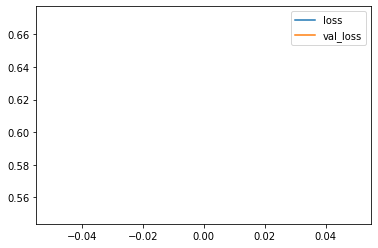

Learning rate: 0.0045


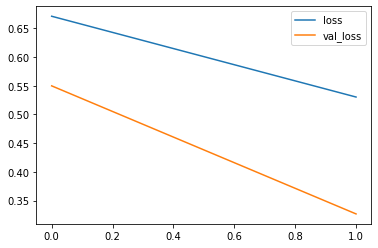

Learning rate: 0.00405


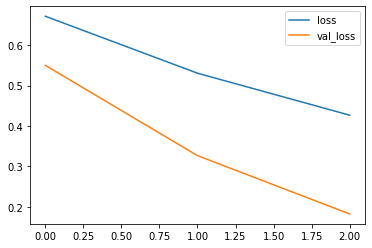

In [0]:
# fit model
train_history = model_origins.fit(
    data_train, labels_train,  # prepared data
    # steps_per_epoch=BATCH_SIZE,
    # validation_steps=BATCH_SIZE,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
               keras.callbacks.LearningRateScheduler(lr_scheduler), 
               LrHistory(), 
               TQDMNotebookCallback(),
               plot_losses
#                keras_utils.ModelSaveCallback(model_filename)
              ],
    validation_data=(data_test, labels_test),
    shuffle=True,
    verbose=0,
    initial_epoch=last_finished_epoch or 0
)

In [0]:
model_origins.save_weights("/content/drive/My Drive/simulation_data/model_origins.h5")

In [0]:
model_origins.load_weights("/content/drive/My Drive/simulation_data/model_origins.h5")

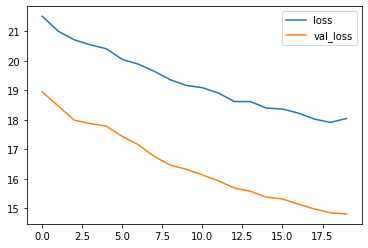

In [0]:
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.show()

# Destinations prediction

In [0]:
X = flows_to_tensor(flows)
Y = trips_to_destinations_tensor(trips)

In [0]:
split_number = round(trips['sim_id'].max() * 0.8)

data_train = X[0:split_number,:,:,:]
labels_train = Y[0:split_number,:,:]
data_test = X[split_number:,:,:]
labels_test = Y[split_number:,:,:]

In [0]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 215
EPOCHS = 3

In [0]:
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model_destinations = make_model_aux()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model_destinations.compile(
    loss='binary_crossentropy',  
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['binary_crossentropy']  # report accuracy during training
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model_destinations.optimizer.lr))

In [0]:
last_finished_epoch = 0

Learning rate: 0.005


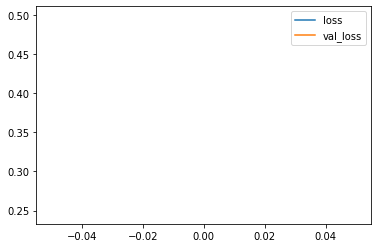

Learning rate: 0.0045


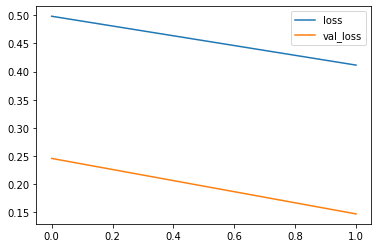

Learning rate: 0.00405


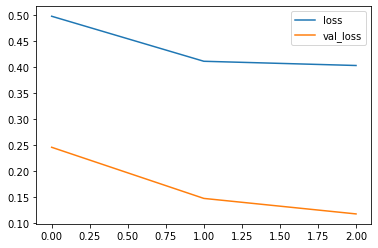

In [0]:
# fit model
train_history = model_destinations.fit(
    data_train, labels_train,  # prepared data
    # steps_per_epoch=BATCH_SIZE,
    # validation_steps=BATCH_SIZE,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
               keras.callbacks.LearningRateScheduler(lr_scheduler), 
               LrHistory(), 
               TQDMNotebookCallback(),
               plot_losses
#                keras_utils.ModelSaveCallback(model_filename)
              ],
    validation_data=(data_test, labels_test),
    shuffle=True,
    verbose=0,
    initial_epoch=last_finished_epoch or 0
)

In [0]:
model_destinations.save_weights("/content/drive/My Drive/simulation_data/model_dest.h5")

In [0]:
model_destinations.load_weights("/content/drive/My Drive/simulation_data/model_dest.h5")

#Final model architecture

In [0]:
def trips_to_tensor(data):
  # only_origins = data[['x_from', 'y_from', 'x_to', 'y_to']].drop_duplicates().sort_values(by=['x_from', 'y_from', 'x_to', 'y_to'])

  data['cell_from'] =  data['x_from'].astype(str).str.cat(data['y_from'].astype(str), sep="_")
  data['cell_to'] =  data['x_to'].astype(str).str.cat(data['y_to'].astype(str), sep="_")
  data['code'] = data['cell_from'].astype(str).str.cat(data['cell_to'].astype(str), sep="_")

  le_cells = preprocessing.LabelEncoder()
  le_cells.fit(data['code'].values)
  data['code_encoded'] = le_cells.transform(data['code'])
  trips_per_sim = data.groupby(['sim_id', 'code_encoded']).size().reset_index()
  return sparse.COO(
      np.transpose(trips_per_sim[['sim_id', 'code_encoded']].values),
      trips_per_sim[0].values,
      shape=((data['sim_id'].max()+1, data['code_encoded'].max()+1))
  )

In [0]:
output = trips_to_tensor(trips)

In [0]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv1D, Conv2D, MaxPooling2D, Flatten, Reshape, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

matrix_size = 32
iterations_number = trips['time'].values.max()+1

def make_final_model():
    model = Sequential()
    model.add(Conv2D(filters=4, kernel_size=(3,3), padding="same"))
    model.add(Activation(LeakyReLU(alpha=0.1)))
    model.add(Conv2D(filters=8, kernel_size=(3,3), padding="same"))
    model.add(Activation(LeakyReLU(alpha=0.1)))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same"))
    model.add(Activation(LeakyReLU(alpha=0.1)))
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same"))
    model.add(Activation(LeakyReLU(alpha=0.1)))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Flatten())
    # model.add(Dropout(0.5))
    # model.add(Dense(2*graph_size**2))
    model.add(Dense(output.shape[1]))
    model.add(Dropout(0.5))
    model.add(Activation(LeakyReLU(alpha=0.1)))

    input_shape = (None, matrix_size, matrix_size, iterations_number)

    model.build(input_shape)
    return model

In [0]:
model = make_final_model()

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [0]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 32, 32, 4)         148       
_________________________________________________________________
activation_19 (Activation)   (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 8)         296       
_________________________________________________________________
activation_20 (Activation)   (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 10, 10, 8)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 800)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 800)              

In [0]:
X = flows_to_tensor(flows)
Y = output

In [0]:
split_number = round(trips['sim_id'].max() * 0.8)

data_train = X[0:split_number,:,:,:]
labels_train = Y[0:split_number,:]
data_test = X[split_number:,:,:]
labels_test = Y[split_number:,:]

In [0]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 215
EPOCHS = 3

In [0]:
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model_final = make_final_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model_final.compile(
    loss='mse',  
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['mse']  # report accuracy during training
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model_final.optimizer.lr))

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Learning rate: 0.005


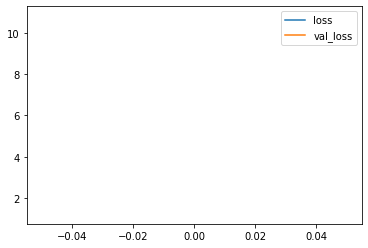

Learning rate: 0.0045


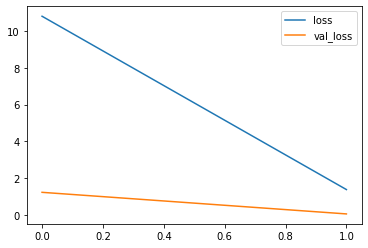

Learning rate: 0.00405


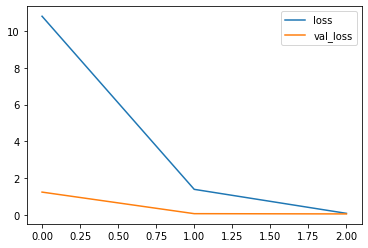

In [0]:
# fit model
train_history = model_final.fit(
    data_train, labels_train,  # prepared data
    # steps_per_epoch=BATCH_SIZE,
    # validation_steps=BATCH_SIZE,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
               keras.callbacks.LearningRateScheduler(lr_scheduler), 
               LrHistory(), 
               TQDMNotebookCallback(),
               plot_losses
#                keras_utils.ModelSaveCallback(model_filename)
              ],
    validation_data=(data_test, labels_test),
    shuffle=True,
    verbose=0,
    initial_epoch=0
)

# Prediction

## Data transformation

In [0]:
def tensor_to_points(data):
  """
  Transforms numpy array with predictions of origins to a pandas dataframe
  """
  dataset = []
  for sim_id in range(data.shape[0]):
    for time in range(data.shape[1]):
      for x in range(data.shape[2]):
        for y in range(data.shape[3]):
          if data[sim_id, time, x, y] > 0.5:
            dataset.append([sim_id, time, x, y])
  return pd.DataFrame(dataset, columns=['sim_id', 'time', 'x', 'y'])

In [0]:
def tensor_to_trips(data):
  """
  Transforms numpy array with predictions to a convinient pandas dataframe

  Args:
    data: numpy array with predictions
  Returns:
    dataframe with the header: [sim_id, time, x_from, y_from, x_to, y_to]
  """
  
  dataset = []
  for sim_id in range(data.shape[0]):
    for time in range(data.shape[1]):
      for cell_from in range(data.shape[2]):
        for cell_to in range(data.shape[3]):
          cell_from_code = le_cells.inverse_transform([cell_from])[0]
          cell_to_code = le_cells.inverse_transform([cell_to])[0]
          x_from, y_from = cell_from_code.split("_")
          x_to, y_to = cell_to_code.split("_")
          number = int(data[sim_id, time, cell_from, cell_to])
          for trips in range(number):
            dataset.append([sim_id, time, x_from, y_from, x_to, y_to])
  return pd.DataFrame(dataset, columns=['sim_id', 'time', 'x_from', 'y_from', 'x_to', 'y_to'])


## Test on new data

### Ground truth

### Predicted data

In [0]:
flows_test = flows[flows['sim_id'] == 10]

In [0]:
trips_predicted = model_final.predict(flows_to_tensor(flows_test))

In [0]:
answer = pd.DataFrame(pd.Series(np.round(trips_predicted[10])))

In [0]:
answer[answer[0]>0]

,0


In [0]:
trips[trips['sim_id']==10].groupby('code_encoded').size()

code_encoded
10       1
71       1
90       1
93       1
106      1
        ..
57993    1
57996    1
58027    1
58057    1
58137    1
Length: 1948, dtype: int64

In [0]:
trips_predicted = tensor_to_points(model_origins.predict([flows_to_tensor(flows_test)[10]]))

NameError: ignored

In [0]:
trips_tests = trips[trips['sim_id']==10]

In [0]:
merged = trips_test[['time', 'x_from', 'y_from']].merge(trips_predicted[['time', 'x', 'y']], how="outer", left_on=['time', 'x_from', 'y_from'], right_on=['time', 'x', 'y'])

In [0]:
merged[merged['x_from'].isna()]

,time,x_from,y_from,x,y
2140,0,NaN,NaN,15.0,0.0
2141,0,NaN,NaN,15.0,0.0
2142,0,NaN,NaN,15.0,0.0
2143,0,NaN,NaN,15.0,0.0
2144,0,NaN,NaN,15.0,0.0
...,...,...,...,...,...
12105,7,NaN,NaN,8.0,0.0
12106,8,NaN,NaN,6.0,3.0
12107,8,NaN,NaN,14.0,0.0
12108,16,NaN,NaN,11.0,0.0


### False negative (not predicted trips)

In [0]:
len(merged[merged['graph_x'].isnull()])

19

### False positive (extra trips)

In [0]:
len(merged[merged['graph_y'].isnull()])

6